# Телеком

В данной работе стоит вопрос оттока клиентов у оператора связи. Для борьбы с этим предлагается вариант раздачи промокодов и специальных условий всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 
<br>Для работы взяты персональные данные о некоторых клиентах, информация об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.
<br>Лучшую модель необходимо выбрать по метрике ROC-AUC. На тестовой выборке должно быть не менее 0,85. Для интерпретируемости модели дополнительно необходимо вывести значение accuracy.

## Загрузка и первичный осмотр данных

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Подготовка данных
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, 
                                   LabelEncoder, RobustScaler, LabelEncoder)

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_recall_curve
import random
import torch
import torch.nn as nn
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential

In [3]:
RANDOM_STATE = 160625

In [4]:
def about_df(list_df):
    '''выводит информацию о всех датасетах из списка list_df'''
    for c, i in enumerate(list_df):
        print("**** DATASET_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        print(f'Количество дубликатов: {i.duplicated().sum()}')
        print('Количество пропущенных значений:', i.isnull().sum(), sep='\n')
        print()

Данные для работы сведены в СУБД, состоящую из 4 таблиц: 
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.
<br>Проверим их:

In [5]:
# подключение к БД
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db 

--2025-07-13 10:42:50--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.52’

ds-plus-final.db.52 100%[===================>]   3.42M  --.-KB/s    in 0.06s   

2025-07-13 10:42:51 (61.3 MB/s) - ‘ds-plus-final.db.52’ saved [3588096/3588096]



In [6]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False) 

In [7]:
#выведем наэкран 5 строк каждой таблицы и количество строк
tables = ['contract', 'personal', 'internet', 'phone']
for i in tables:
    query = f'''
    SELECT *
    FROM {i}
    LIMIT 5
    '''
    print('Таблица', i + ':')
    display(pd.read_sql_query(query, con=engine))
    
    query = f'''
    SELECT count(DISTINCT customerID)
    FROM {i}
    '''
    display(pd.read_sql_query(query, con=engine))
    print()

Таблица contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


,count(DISTINCT customerID)
0,7043



Таблица personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,count(DISTINCT customerID)
0,7043



Таблица internet:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,count(DISTINCT customerID)
0,5517



Таблица phone:


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,count(DISTINCT customerID)
0,6361


**Вывод**
<br>В таблицах `contract` и `personal` имются записи о 7043 клиентах. В `internet` и `phone` их 5517 и 6361 соответственно. Большинство столбцов в таблицах `personal`, `internet` и `phone` бинарные (Yes или No).

## Исследовательский анализ и предобработка данных

Ввиду того, что база данных небольшая, для удобства запишем таблицы в датафреймы:

In [8]:
for i in tables:
    query = f'''
    SELECT *
    FROM {i}
    '''
    globals()[i] = pd.read_sql_query(query, con=engine)

Все колонки имеют формат строки, поэтому вначале приведем в соответсвие формат колонок:

In [9]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


Поскольку в проекте стоит задача составить модель, которая будет предсказывать, разорвёт ли абонент договор, то таргет сделаем бинарным:

In [10]:
contract['Left'] = ['No' if x == 'No' else 'Yes' for x in contract['EndDate']]

In [11]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype(float)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')  # неестественные форматы заменим на nan

# заменим даты
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

# в колонке EndDate заменим значение NO текущей датой
contract['EndDate'] = contract['EndDate'].replace('No', date.today())
# contract['EndDate'] = contract['EndDate'].replace('No', contract['BeginDate'].max() + datetime.timedelta(days=1))

In [12]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

display('Максимальная дата начала договора', contract['BeginDate'].max())
display('Максимальная дата окончания договора', contract['EndDate'].max())

'Максимальная дата начала договора'

Timestamp('2020-02-01 00:00:00')

'Максимальная дата окончания договора'

Timestamp('2025-07-13 00:00:00')

In [13]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
phone.head()

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
# переименуем колонку с id пользователя в таблице phone для однообразия

phone = phone.rename(columns={"CustomerId": "customerID"})

В таблице `contract` колонки с датами и числами приведены в соответствующие форматы. В таблицах `personal`, `internet`, `phone` все колонки типа object. Проверим датафреймы на наличие неявных пропусков, дубликатов:

In [17]:
tables = [contract, personal, internet, phone]

for i, tabl in enumerate(tables):
    print('Таблица', i+1)
    cat_cols = list(tabl.select_dtypes(include=['object']).columns[1:]) # выберем колонки с типом object без колонки с ID
    for col in cat_cols:
        print('Колонка', col)
        print(tabl[col].unique())
        print()
    print('------------------')

Таблица 1
Колонка Type
['Month-to-month' 'One year' 'Two year']

Колонка PaperlessBilling
['Yes' 'No']

Колонка PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Колонка Left
['No' 'Yes']

------------------
Таблица 2
Колонка gender
['Female' 'Male']

Колонка SeniorCitizen
['0' '1']

Колонка Partner
['Yes' 'No']

Колонка Dependents
['No' 'Yes']

------------------
Таблица 3
Колонка InternetService
['DSL' 'Fiber optic']

Колонка OnlineSecurity
['No' 'Yes']

Колонка OnlineBackup
['Yes' 'No']

Колонка DeviceProtection
['No' 'Yes']

Колонка TechSupport
['No' 'Yes']

Колонка StreamingTV
['No' 'Yes']

Колонка StreamingMovies
['No' 'Yes']

------------------
Таблица 4
Колонка MultipleLines
['No' 'Yes']

------------------


Неявных пропусков и дублей в категориальных колонках не осталось. Теперь посмотрим информацию о представленных данных:

In [18]:
about_df(tables)

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Left              7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 495.3+ KB


None

,MonthlyCharges,TotalCharges
count,7043.00,7032.00
mean,64.76,2118.62
std,30.09,2112.74
min,18.25,19.05
25%,35.50,439.74
50%,70.35,1345.28
75%,89.85,3239.32
max,118.75,9221.38


Количество дубликатов: 0
Количество пропущенных значений:
customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Left                 0
dtype: int64

**** DATASET_2 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7554-AKDQF,Male,0,No,No
freq,1,3555,5901,3641,4933


Количество дубликатов: 0
Количество пропущенных значений:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

**** DATASET_3 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7554-AKDQF,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество дубликатов: 0
Количество пропущенных значений:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

**** DATASET_4 ****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7554-AKDQF,No
freq,1,3390


Количество дубликатов: 0
Количество пропущенных значений:
customerID       0
MultipleLines    0
dtype: int64



Видно, что в датафрейме `contract` появились пропущенные значения в колонке TotalCharges. Разберемся с ними на этапе объединения датасетов.

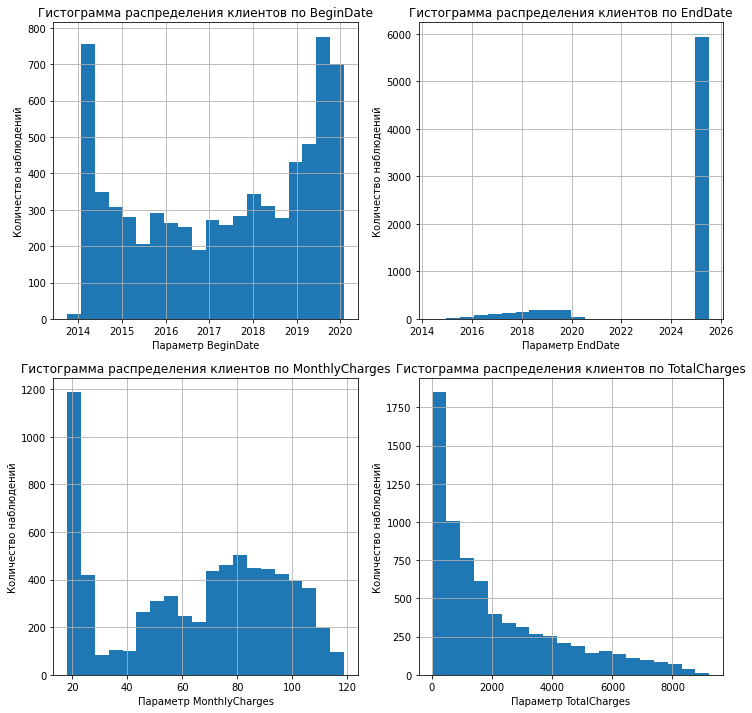

In [19]:
# Посмотрим на распределение числовых и временных признаков в датафрейме contract
temp = ['BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
#    fig.subplots_adjust(hspace=0.3)
axe = axes.ravel()
    
for i, c in enumerate(temp):
    contract[c].hist(bins=20, figsize=(12, 12), ax=axe[i])
    axe[i].set_title(f'Гистограмма распределения клиентов по {c}')
    axe[i].set_xlabel(f'Параметр {c}')
    axe[i].set_ylabel('Количество наблюдений');

Из построенных гистограмм видно, что данные имеются от 2013 до 2020 года. Заметен рост числа заключенных договоров начиная с 2017 года. Также заметно, что большинство пользователей либо продолжают платить по договору, либо расторгли его в 2020 году. Распредление месячной оплаты походит на нормальное с большим количеством минимальной оплаты, а распределение общих расходов абонента носят геометрический характер. Аномальных значений не выявлено. 

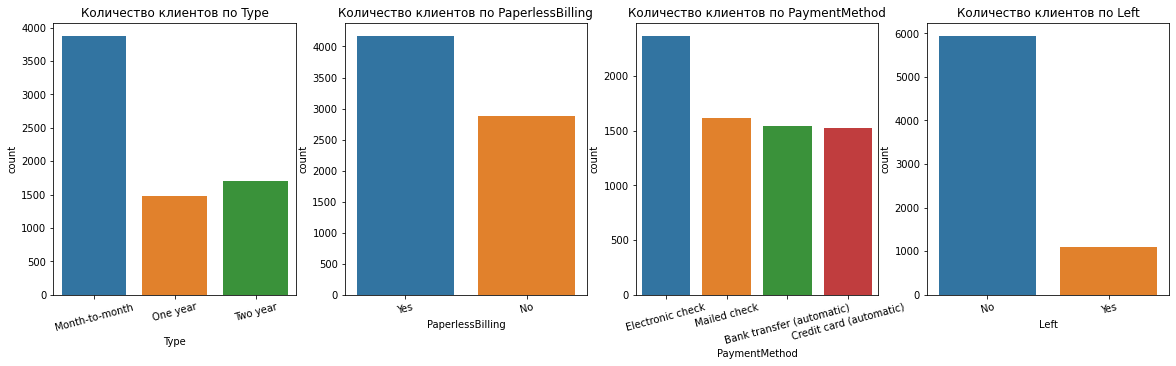

In [20]:
# countplots для датафрейма contract
cat_cols = list(contract.select_dtypes(include=['object']).columns[1:]) # выберем колонки с типом object без колонки с ID

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(hspace=0.3)
axe = axes.ravel()
for i, c in enumerate(cat_cols):
    cnt_plot = sns.countplot(data = contract, x=c, ax=axe[i])
    plt.setp(cnt_plot.get_xticklabels(), rotation=15)
    cnt_plot.set(title=f'Количество клиентов по {c}')  

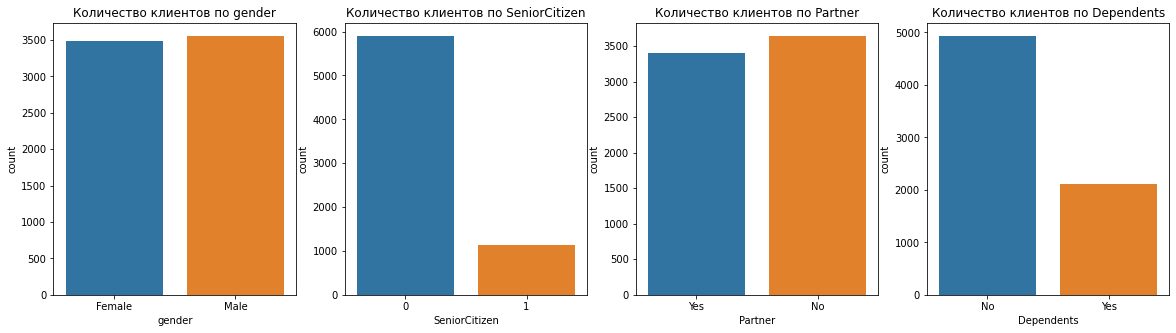

In [21]:
# countplots для датафрейма personal
cat_cols = list(personal.select_dtypes(include=['object']).columns[1:]) # выберем колонки с типом object без колонки с ID

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(hspace=0.3)
axe = axes.ravel()
for i, c in enumerate(cat_cols):
    cnt_plot = sns.countplot(data = personal, x=c, ax=axe[i])
#    plt.setp(cnt_plot.get_xticklabels(), rotation=15)
    cnt_plot.set(title=f'Количество клиентов по {c}')  

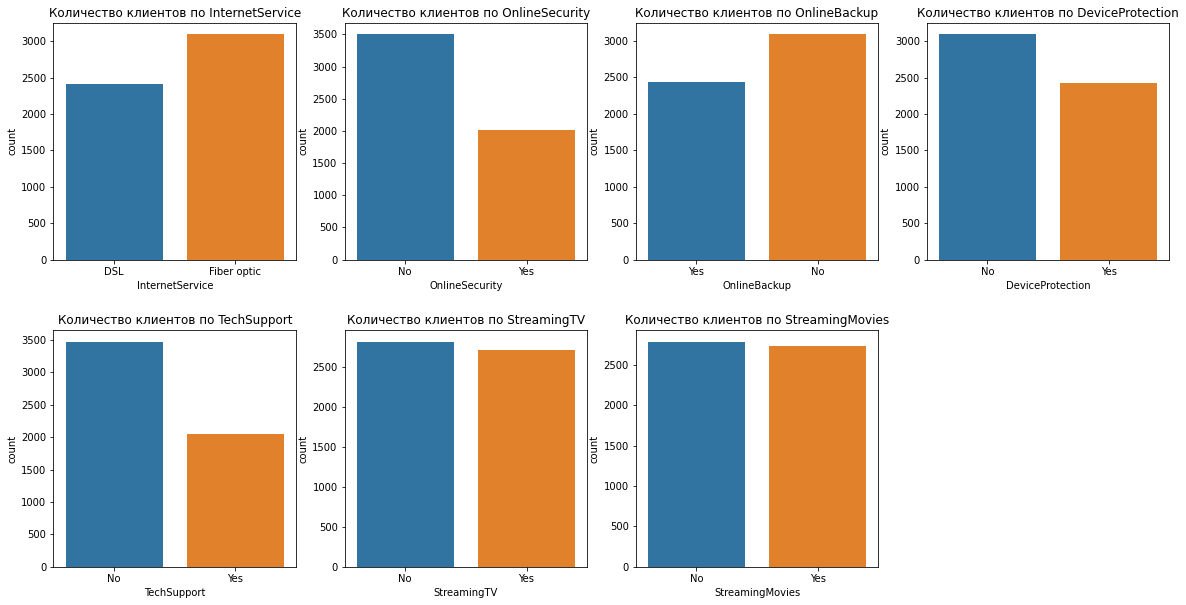

In [22]:
# countplots для датафрейма internet
cat_cols = list(internet.select_dtypes(include=['object']).columns[1:]) # выберем колонки с типом object без колонки с ID

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.3)
axe = axes.ravel()
for i, c in enumerate(cat_cols):
    cnt_plot = sns.countplot(data = internet, x=c, ax=axe[i])
#    plt.setp(cnt_plot.get_xticklabels(), rotation=15)
    cnt_plot.set(title=f'Количество клиентов по {c}') 
fig.delaxes(axes.flatten()[7])

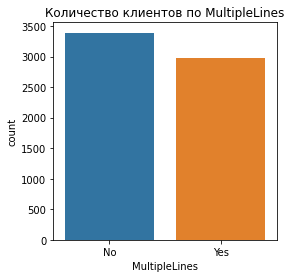

In [23]:
# countplot для датафрейма phone
plt.figure(figsize=(4, 4))
cnt_plot = sns.countplot(data = phone, x='MultipleLines')
# plt.setp(cnt_plot.get_xticklabels(), rotation=15)
cnt_plot.set(title=f'Количество клиентов по MultipleLines');

Из построенных графиков видно, что по большей части клиенты остаются у нашего оператора связи и не уходят. Большинство клиентов оплачивают услуги ежемесячно, получают электронный расчетный лист. Большинство счетов оплачивается электронно, прочие способы оплаты представленны примерно в равных долях. Нет сильной разницы в распределении пользователей по полу, наличию супруга/супруги, подключенного стримингового телевидиния и каталога фильмов. Большинство пользователей не является пенсионерами, не имеют детей, подключаются по оптическому кабелю, не имеют блокировки опасных сайтов, не пользуются облачным хранилищем, антивирусом, техподдержкой.

In [24]:
# для дальнейшей работы объеденим все таблицы в одну (оставим все данные)

data = contract.merge(personal, on='customerID', how='outer')\
               .merge(internet, on='customerID', how='outer')\
               .merge(phone, on='customerID', how='outer')

In [25]:
about_df([data])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Left              7043 non-null   object        
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  Onli

None

,MonthlyCharges,TotalCharges
count,7043.00,7032.00
mean,64.76,2118.62
std,30.09,2112.74
min,18.25,19.05
25%,35.50,439.74
50%,70.35,1345.28
75%,89.85,3239.32
max,118.75,9221.38


Количество дубликатов: 0
Количество пропущенных значений:
customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Left                   0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64



Видно, что появилось много пропусков, перешедших из датафреймов `internet` и  `phone` (ввиду меньшего количества пользователей в этих датафреймах). Поскольку удалить строки с пропущенными значениями нельзя (т.к. их много), то заменим пропуски на значение unknown.  Строки с пропусками в TotalCharges удалим, ввиду того, что их всего 11 (0,15% от всего датафрейма):

In [26]:
data[data['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Left,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,2025-07-13,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,2025-07-13,Two year,No,Mailed check,20.25,NaN,No,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,2025-07-13,Two year,No,Mailed check,80.85,NaN,No,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2025-07-13,Two year,No,Mailed check,25.75,NaN,No,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,2025-07-13,Two year,No,Credit card (automatic),56.05,NaN,No,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,2025-07-13,Two year,No,Mailed check,19.85,NaN,No,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,2025-07-13,Two year,No,Mailed check,25.35,NaN,No,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,2025-07-13,Two year,No,Mailed check,20.00,NaN,No,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,2025-07-13,One year,Yes,Mailed check,19.70,NaN,No,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,2025-07-13,Two year,No,Mailed check,73.35,NaN,No,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [27]:
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'])

In [28]:
data.iloc[[488]]  # для проверки

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Left,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,2025-07-13,Two year,Yes,Bank transfer (automatic),52.55,52.55,No,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN


In [30]:
data_1 = data.fillna('NoMainService')

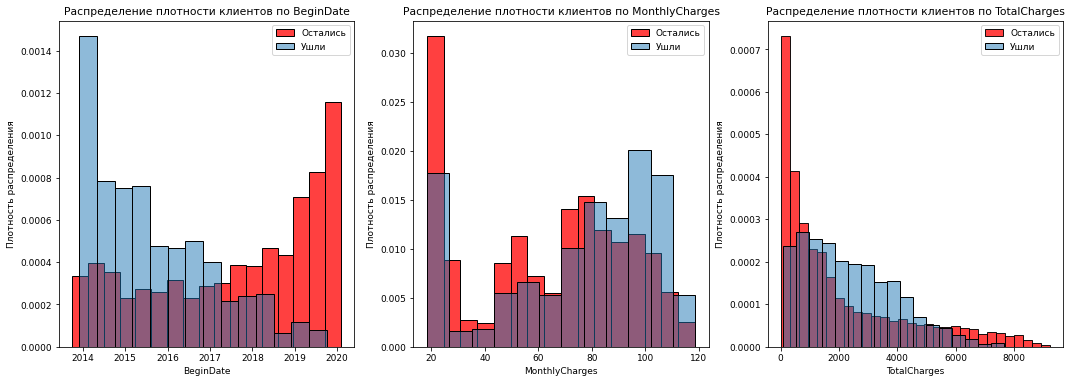

In [31]:
# посмотрим на распределение численных признаков в зависимости от того, ушел клиент или нет

temp_1 = data_1.query('Left == "No"')     # разобьем данные на две выборки по прерыванию договора
temp_2 = data_1.query('Left == "Yes"')
temp = ['BeginDate', 'MonthlyCharges', 'TotalCharges']   # числовые колонки для гистограмм

# построим гистограммы
plt.rcParams.update({'font.size': 9})
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axe = axes.ravel()

for i, c in enumerate(temp):
    sns.histplot(data=temp_1[c], label='Остались', ax=axe[i], 
                 stat='density', common_norm=False, color='red')
    sns.histplot(data=temp_2[c], label='Ушли', ax=axe[i], alpha=0.5, 
                 stat='density', common_norm=False)
    axe[i].set_title(f'Распределение плотности клиентов по {c}')
    axe[i].set_xlabel(c)
    axe[i].set_ylabel('Плотность распределения')
    axe[i].legend()

На основании построенных гистограмм можно сделать вывод, что чем дольше клиент пользуется услугами оператора, тем больше вероятность его ухода. Поэтому клиентам, которые долго пользуются связью можно раздать бонусы. Клиенты, которые платят больше в месяц также имеют более высокую вероятность ухода.

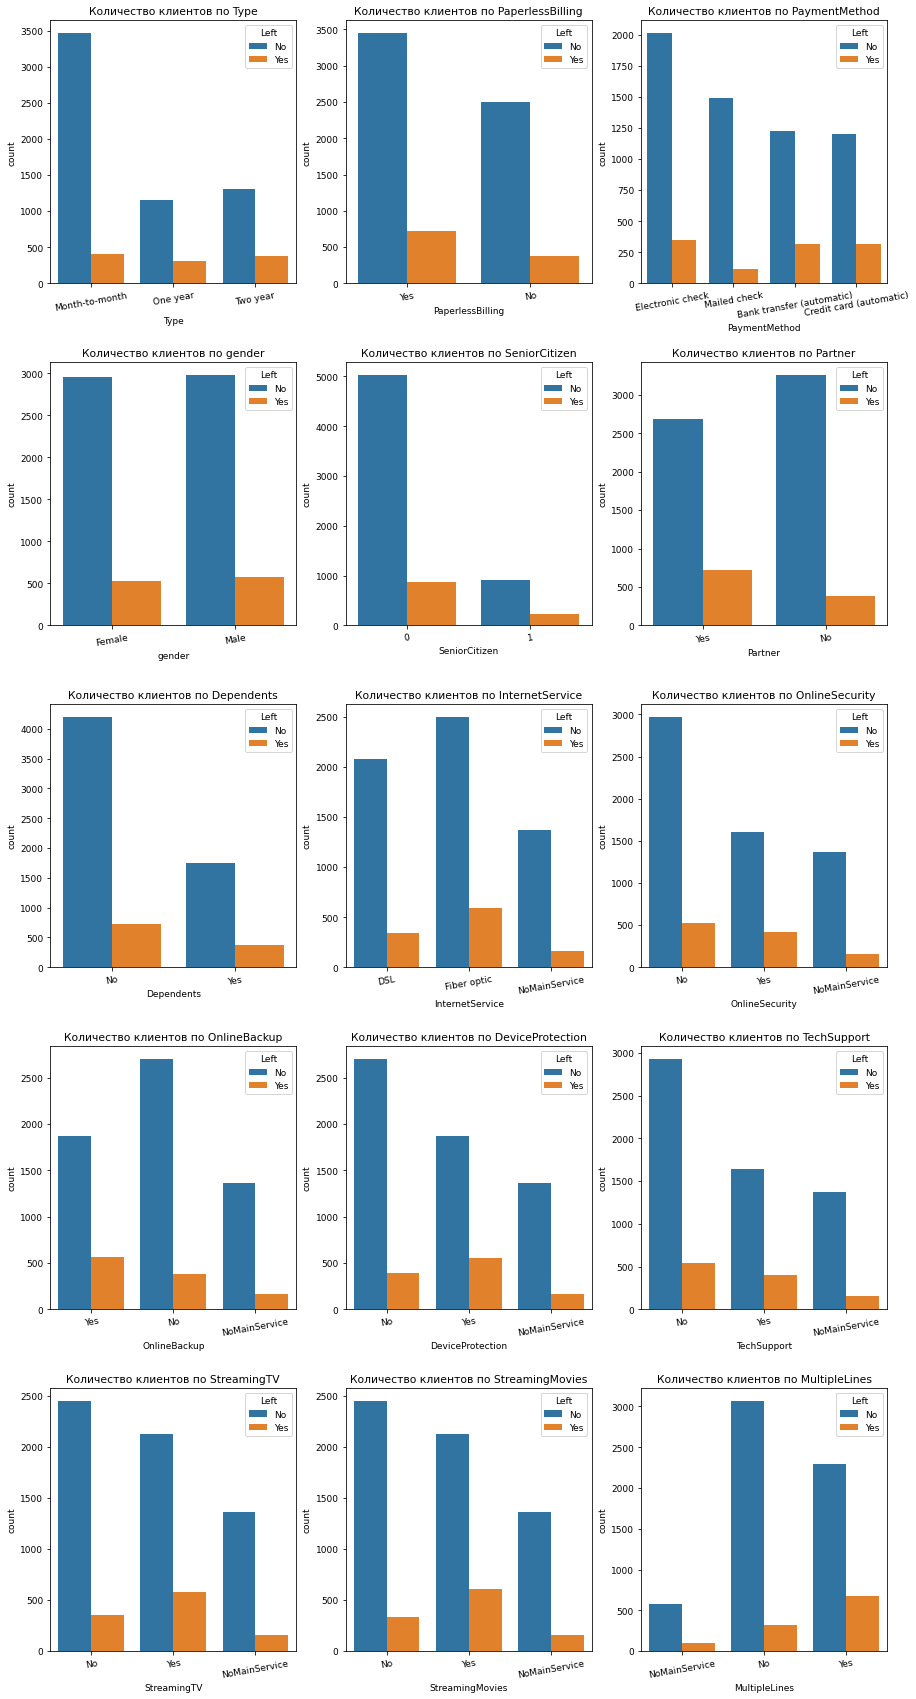

In [32]:
# посмотрим как делятся ушедшие и оставшиеся пользователи по категориальным признакам

temp = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
        'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

fig, axes = plt.subplots(5, 3, figsize=(15, 30))
fig.subplots_adjust(hspace=0.3)
axe = axes.ravel()
    
for i, c in enumerate(temp):
    cnt_plot = sns.countplot(x=c, hue = 'Left', data = data_1, ax=axe[i])
    plt.setp(cnt_plot.get_xticklabels(), rotation=10)
    cnt_plot.set(title=f'Количество клиентов по {c}')

По построенным барплотам можно сделать выводы: 
- не особо сильно влияют на уход клиентов (количество ушедших и оставшихся клиентов в приблизительно равных долях): тип оплаты, пол, наличие электронного расчётного листа, пенсионный ли возраст, наличие детей, тип подключения, наличие тех.поддержки;
- чаще уходят люди с любым способом оплаты кроме отправки бумажного чека, имеющие супруга, имеющие блокировку опасных сайтов, пользующиеся облачным хранилищем и антивирусом, пользующимися услугами стримингового ТВ и каталогом фильмов, а также имеющие подключение телефона к нескольким линиям одновременно.
<br>Также видно, что во всех признаках unknown занимает меньше всего данных.

Корреляционный анализ данных выполним для датафрейма data (без выполненной замены пропусков на unknown) и для датафрейма data_1 с заменой пропусков

In [33]:
data = data.drop('customerID', axis=1) # удалим неинформативный ИД
interval_cols = list(data._get_numeric_data().columns)
phik_overview = data.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(20, 20)


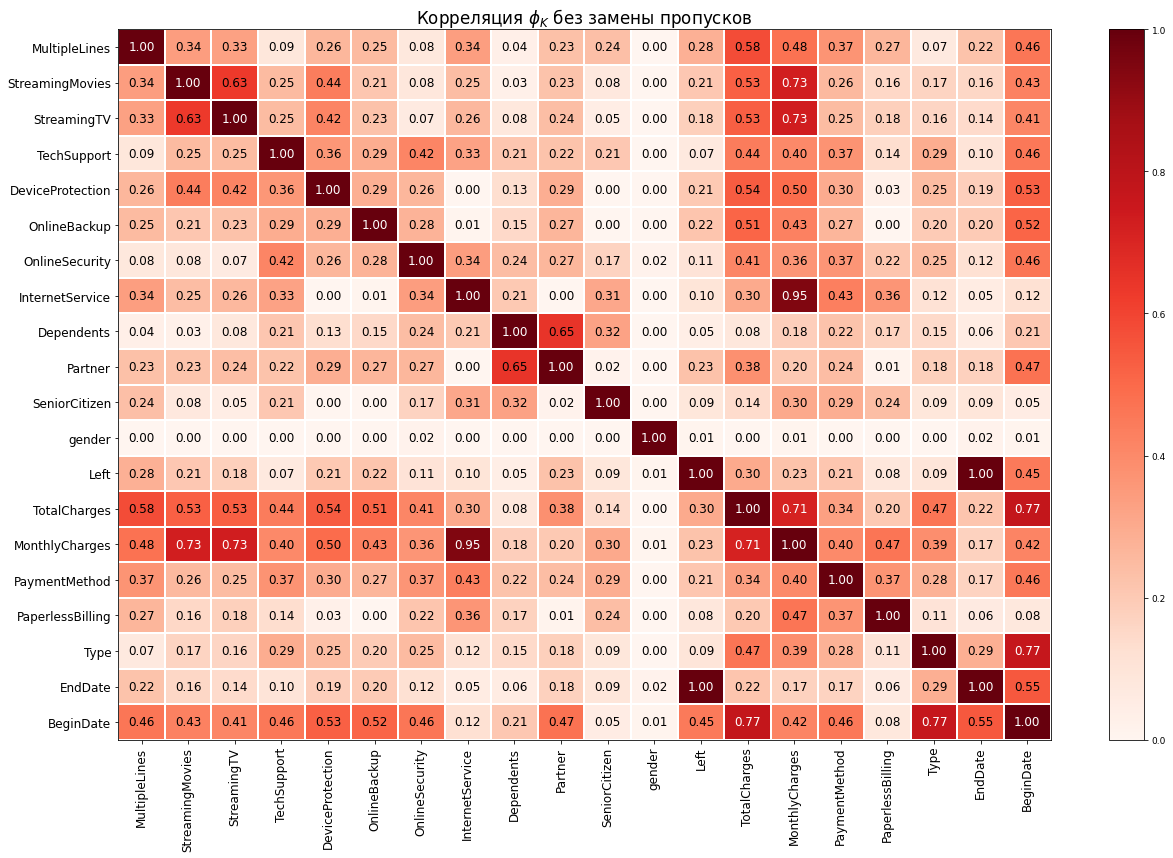

In [34]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляция $\phi_K$ без замены пропусков',
    fontsize_factor=1.2,
    figsize=(18, 12)) 

In [35]:
data_1 = data_1.drop('customerID', axis=1) # удалим неинформативный ИД
interval_cols = list(data_1._get_numeric_data().columns)
phik_overview = data_1.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(20, 20)


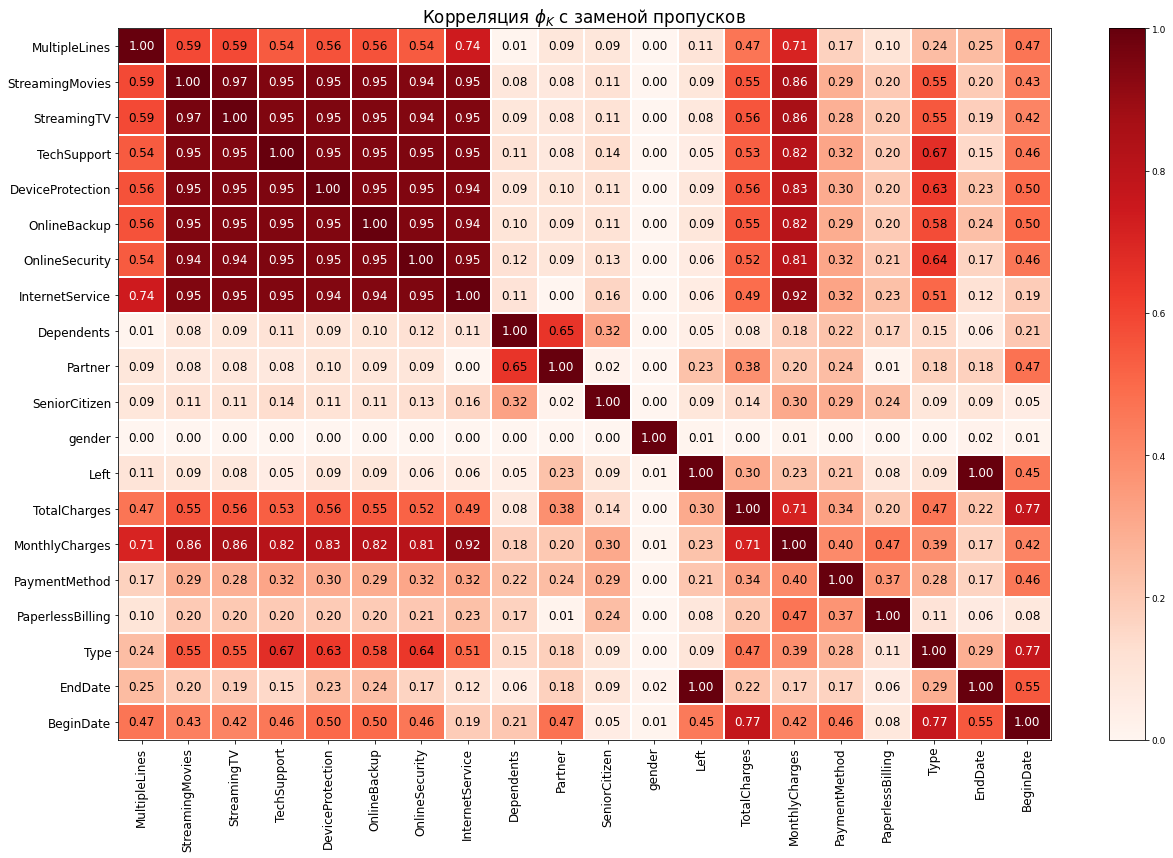

In [36]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляция $\phi_K$ с заменой пропусков',
    fontsize_factor=1.2,
    figsize=(18, 12)) 

Судя по построенным корреляциям, данные, взятые ранее из таблиц `internet` и `phone` с заменой пропусков на unknown, почти не влияют на таргет (Left). Если точно заменить пропуски из датафрейма `internet` то корреляция с таргетом в среднем с 0,09 повысится примерно до 0,21. Ниболее сильно с таргетом коррелируют дата начала действия договора и общая оплаченная сумма. 
<br>Стоит отметить, что общая оплаченная сумма косвенно коррелирует с датой начала действия договора, поскольку чем раньше клиент заключил договор, тем больше в итоге он заплатил.

**Вывод**
<br>Для работы все таблицы были объеденены в одну. Колонки были приведены к соответствующим форматам. Итоговый признак был определен как уйдет клиент или нет (Yes или No). 
<br>Из построенных гистограмм/ графиков на этапе EDA видно, что данные имеются от 2013 до 2020 года. Заметен рост числа заключенных договоров начиная с 2017 года. Также заметно, что большинство пользователей либо продолжают платить по договору, либо расторгли его в 2020 году. Распредление месячной оплаты походит на нормальное с большим количеством минимальной оплаты, а распределение общих расходов абонента носят геометрический характер. Аномальных значений не выявлено. Также заметно, что по большей части клиенты остаются у нашего оператора связи и не уходят. Большинство клиентов оплачивают услуги ежемесячно, получают электронный расчетный лист. Большинство счетов оплачивается электронно, прочие способы оплаты представленны примерно в равных долях. Нет сильной разницы в распределении пользователей по полу, наличию супруга/супруги, подключенного стримингового телевидиния и каталога фильмов. Большинство пользователей не является пенсионерами, не имеют детей, подключаются по оптическому кабелю, не имеют блокировки опасных сайтов, не пользуются облачным хранилищем, антивирусом, техподдержкой.
<br>По распределению ушедших и оставшихся клиентов можно сделать выводы: 
- что чем дольше клиент пользуется услугами оператора, тем больше вероятность его ухода. Поэтому клиентам, которые долго пользуются связью можно раздать бонусы. Клиенты, которые платят больше в месяц также имеют более высокую вероятность ухода;
- не особо сильно влияют на уход клиентов (количество ушедших и оставшихся клиентов в приблизительно равных долях): тип оплаты, пол, наличие электронного расчётного листа, пенсионный ли возраст, наличие детей, тип подключения, наличие тех.поддержки;
- чаще уходят люди с любым способом оплаты кроме отправки бумажного чека, имеющие супруга, имеющие блокировку опасных сайтов, пользующиеся облачным хранилищем и антивирусом, пользующимися услугами стримингового ТВ и каталогом фильмов, а также имеющие подключение телефона к нескольким линиям одновременно.
<br>Также видно, что во всех признаках unknown занимает меньше всего данных.
<br>Судя по построенным корреляциям, данные, взятые ранее из таблиц `internet` и `phone` с заменой пропусков на unknown, почти не влияют на таргет (Left). Если точно заменить пропуски из датафрейма `internet` то корреляция с таргетом в среднем с 0,09 повысится примерно до 0,21. Ниболее сильно с таргетом коррелируют дата начала действия договора и общая оплаченная сумма. 
<br>Стоит отметить, что общая оплаченная сумма косвенно коррелирует с датой начала действия договора, поскольку чем раньше клиент заключил договор, тем больше в итоге он заплатил.

## Подготовка данных для обучения

Добавим новые признаки: 
- BeginYear: год начала действия контракта;
- CntServices: количство подключенных услуг у клиента.

In [37]:
# признак begin_year
data_1['BeginYear'] = data_1['BeginDate'].dt.year

# признак cnt_services
data_1['CntServices'] = data_1[['OnlineSecurity', 'OnlineBackup', 
                                 'DeviceProtection', 'TechSupport', 
                                 'StreamingTV', 'StreamingMovies']].applymap(lambda x: str.count(x, 'Yes')).sum(axis=1)

Для моделирования отберем следующие признаки: Parthner, MonthlyCharges,	TotalCharges, PaymentMethod, MultipleLines, StreamingMovies, BeginYear, CntServices.

In [38]:
data_final = data_1[['Partner', 'MonthlyCharges', 'TotalCharges', 
                     'PaymentMethod', 'MultipleLines', 'StreamingMovies', 
                     'BeginYear', 'CntServices', 'Left']]

In [39]:
data_final.head(3)

,Partner,MonthlyCharges,TotalCharges,PaymentMethod,MultipleLines,StreamingMovies,BeginYear,CntServices,Left
0,Yes,29.85,31.04,Electronic check,NoMainService,No,2020,1,No
1,No,56.95,2071.84,Mailed check,No,No,2017,2,No
2,No,53.85,226.17,Mailed check,No,No,2019,2,No


In [40]:
interval_cols = list(data_final._get_numeric_data().columns)
phik_overview = data_final.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(9, 9)


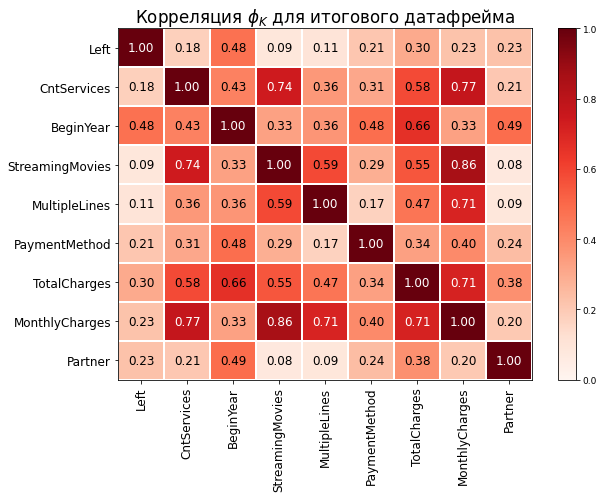

In [41]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Корреляция $\phi_K$ для итогового датафрейма',
    fontsize_factor=1.2,
    figsize=(9, 7)) 

In [42]:
about_df([data_final])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Partner          7043 non-null   object 
 1   MonthlyCharges   7043 non-null   float64
 2   TotalCharges     7043 non-null   float64
 3   PaymentMethod    7043 non-null   object 
 4   MultipleLines    7043 non-null   object 
 5   StreamingMovies  7043 non-null   object 
 6   BeginYear        7043 non-null   int64  
 7   CntServices      7043 non-null   int64  
 8   Left             7043 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 808.3+ KB


None

,MonthlyCharges,TotalCharges,BeginYear,CntServices
count,7043.00,7043.00,7043.00,7043.00
mean,64.76,2115.38,2016.88,2.04
std,30.09,2112.68,1.97,1.85
min,18.25,19.05,2013.00,0.00
25%,35.50,436.75,2015.00,0.00
50%,70.35,1343.35,2017.00,2.00
75%,89.85,3236.69,2019.00,3.00
max,118.75,9221.38,2020.00,6.00


Количество дубликатов: 48
Количество пропущенных значений:
Partner            0
MonthlyCharges     0
TotalCharges       0
PaymentMethod      0
MultipleLines      0
StreamingMovies    0
BeginYear          0
CntServices        0
Left               0
dtype: int64



In [43]:
# удалим дубли
data_final = data_final.drop_duplicates().reset_index(drop=True)
data_final.duplicated().sum()

0

In [44]:
# деление на тренировочную, тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_final.drop('Left', axis=1), 
                                                    data_final['Left'], 
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=data_final['Left'])

print('train size:', X_train.shape, ' test size:', X_test.shape)

train size: (5246, 8)  test size: (1749, 8)


In [45]:
y_train.value_counts()   # для проверки

No     4421
Yes     825
Name: Left, dtype: int64

In [46]:
y_test.value_counts()   # для проверки

No     1474
Yes     275
Name: Left, dtype: int64

In [47]:
# кодирование таргета
le = LabelEncoder()
le.fit(y_train)
le.classes_ = np.array(['No', 'Yes'])

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [48]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

In [49]:
y_test

array([1, 0, 1, ..., 0, 0, 0])

In [50]:
cat_columns = ['Partner', 'PaymentMethod', 'MultipleLines',   # численные и категориальные колонки
               'StreamingMovies']

num_columns = ['MonthlyCharges', 'TotalCharges', 'BeginYear',
               'CntServices']

**Вывод**
<br> Для работы было разработано 2 новых признака: год заключения договора и количество услуг у клиентов. Оба они неплохо коррелируют с таргетом (Left). В итоге из датасета были оставлены 8 признаков: Parthner, MonthlyCharges, TotalCharges, PaymentMethod, MultipleLines, StreamingMovies, BeginYear, CntServices.

## Обучение моделей, выбор лучшей

Лучшую модель будем выбирать с помощью пайплайна.
В пайплайне будут сравниваться две модели: RandomForestClassifier, CatBoostClassifier. Для сравнения моделей была принята метрика ROC-AUC.

In [51]:
# пайплайн для кодирования

ord_pipe = Pipeline(
    [('simpeImputer_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10))])

data_preprocessor = ColumnTransformer(
    [('cat', ord_pipe, cat_columns),
     ('num', StandardScaler(), num_columns)], remainder='passthrough')

In [52]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))])

param_grid = [

    # модель RandomForestClassifier
     {'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
      'models__max_features': [5, 10],
      'models__min_samples_split': [5, 10],
      'preprocessor__cat': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
                            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10),
                            'passthrough'],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # модель CatBoostClassifier
     {'models': [CatBoostClassifier(silent=True, random_state=RANDOM_STATE)],
      'preprocessor__cat': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
                            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10),
                            'passthrough'],
      'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]

In [53]:
best_model = GridSearchCV(pipe_final,
                          param_grid,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1)

In [54]:
best_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpeImputer_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=10))]),
                                                                         ['Partner',
                                                                          'PaymentMethod',
                                                                          'MultipleLines',
                                                                          'StreamingMovies']),
                                                                        ('num',
                                                                         St...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7f44e29b8370>],
                          'preprocessor__cat': [OneHotEncoder(drop='first',
                                                              handle_unknown='ignore',
                                                              sparse_output=False),
                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                               unknown_value=10),
                                                'passthrough'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [55]:
print('Метрика ROC-AUC лучшей модели:', best_model.best_score_)

Метрика ROC-AUC лучшей модели: 0.94749366675345


Среди RandomForestClassifier, CatBoostClassifier и нейросети лучше оказалась CatBoostClassifier с метрикой ROC-AUC = 0.947. 
<br>нейронная сеть (параметры: 12 входных нейронов, 8 и 4 нейронов в двух скрытых слоях, оптимизатор - Adam) справилась немного хуже чем Catboosting.

Проверим, как сработает нейросеть:

In [56]:
# деление на тренировочную и валидационную выборки
X_train_net, X_val_net, y_train_net, y_val_net = train_test_split(X_train, 
                                                                  y_train, 
                                                                  test_size=0.25, 
                                                                  random_state=RANDOM_STATE,
                                                                  stratify=y_train)

print('train_net size:', X_train_net.shape, ' val_net size:', X_val_net.shape)

train_net size: (3934, 8)  val_net size: (1312, 8)


In [57]:
# кодирование и масштабирование
col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), num_columns),
                            ('ohe', OneHotEncoder(drop='first', 
                                                  handle_unknown='ignore', 
                                                  sparse_output=False), cat_columns)],
                        remainder='passthrough'
                                  )

col_transformer.fit(X_train_net)
X_train_net = col_transformer.transform(X_train_net)
X_val_net = col_transformer.transform(X_val_net)

In [58]:
# перевод в тензоры
X_train_net = torch.FloatTensor(X_train_net)
X_val_net = torch.FloatTensor(X_val_net)
y_train_net = torch.FloatTensor(y_train_net)
y_val_net = torch.FloatTensor(y_val_net)

In [59]:
# инициализация нейросети
net = nn.Sequential(
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.Tanh(),
    nn.Linear(4, 1), 
    nn.Sigmoid()
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.BCELoss()

num_epochs = 3000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_train_net).flatten()
            
    loss_value = loss(preds, y_train_net)
    loss_value.backward()
            
    optimizer.step()
    
    if epoch % 50 == 0 or epoch == num_epochs :
        net.eval()
        val_preds = net.forward(X_val_net).detach().numpy()
        roc_auc = roc_auc_score(y_val_net, val_preds)
        print(roc_auc)

0.30542363805544337
0.5273925104022191
0.6363875770290911
0.6921733176495374
0.7338085289418705
0.7745351919801963
0.8182069558805456
0.8565591039168525
0.8818536140030548
0.9002967046472024
0.9114319071612915
0.9176074018153408
0.9211099211713688
0.9243490932073949
0.9276058217314209
0.9299583911234398
0.9315033620674521
0.9332897347214664
0.9351902245474816
0.9366913042714935
0.938495233413508
0.9399260871855195
0.9405625098755245
0.9413481627135308
0.9419055812075353
0.9426956231675415
0.9429063010235432
0.9429414139995435
0.9425507821415404
0.9426692884355414
0.9425727277515406
0.9424673888235398
0.9424147193595394
0.9423313260415387
0.9419758071595358
0.942002141891536
0.9418353552555347
0.9417124598395337
0.9417651293035342
0.9417958531575343
0.9417519619375341
0.9413525518355309
0.9411682087115294
0.9410277568075283
0.9407951333415263
0.9406634596815252
0.9405668989975245
0.9405361751435243
0.9406546814375253
0.9407556312435261
0.940623957583525
0.9405756772415246
0.940768798609

**Вывод**
<br> Среди трех моделей: RandomForestClassifier, CatBoostClassifier и Нейронная сеть, состоящая из 12 входных нейронов, 8 и 4 нейронов в двух скрытых слоях лучшую метрику на валидации показала модель CatBoostClassifier с метрикой ROC-AUC = 0.947. Нейронная сеть не слишком далеко от нее отстала. Для дальнейшей работы рассмотрим catboost и НС.

## Тестирование лучшей модели

In [60]:
# расчитаем таргет по лучшей модели
y_test_pred = best_model.best_estimator_.predict(X_test)
y_test_pred

array([0, 0, 1, ..., 0, 0, 0])

In [61]:
def roc_auc_acc_score(y_test, y_test_pred):
    
    '''Расчет метрики ROC-AUC и accuracy'''
    
    print('ROC-AUC:', round(roc_auc_score(y_test, y_test_pred), 3))
    print('Accuracy:', round(accuracy_score(y_test, y_test_pred), 3))

In [62]:
roc_auc_acc_score(y_test, y_test_pred)

ROC-AUC: 0.892
Accuracy: 0.965


Видно, что ROC-AUC на тесте (0,89) несколько хуже, чем на кросс-валидации, но все-равно выше необходимого порога в 0,85. Расчет метрики accuracy говорит о том, что в 96 из 100 случаев модель точно предсказывает, уйдет ли клиент от оператора связи. Если всем наблюдениям присвоить наиболее частое значение (No), то accuracy будет = 0,84. Для сравнения посмотрим, как с этой ролью справится НС.

In [63]:
# кодирование и масштабирование X_test
X_test_net = col_transformer.transform(X_test)

# перевод в тензоры
X_test_net = torch.FloatTensor(X_test_net)

# предикт таргета
y_test_pred_net = net.forward(X_test_net).detach().numpy()

# для проверки
y_test_pred_net

array([[0.00286815],
       [0.00332497],
       [0.9962541 ],
       ...,
       [0.01279559],
       [0.01013768],
       [0.01844138]], dtype=float32)

In [64]:
# перевод в бинарный вид для расчета метрик
net_bin_preds = (y_test_pred_net > 0.5).astype('int32')
net_bin_preds

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [65]:
roc_auc_acc_score(y_test, net_bin_preds)

ROC-AUC: 0.913
Accuracy: 0.966


Видно, что при использовании НС метрика ROC-AUC стала немного лучше, чем при использовании Catboost, но при этом значение точности (accuracy) стало немнго меньше. Сравним ответы построив матрицу ошибок для двух моделей:

In [66]:
def create_conf_matrix(y_true, y_pred):
    
    '''Построение матрицы ошибок для анализа'''
    
    conf_m = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_m, annot=True)
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказание')
    plt.ylabel('Истина');
    display(conf_m)

array([[1472,    2],
       [  59,  216]])

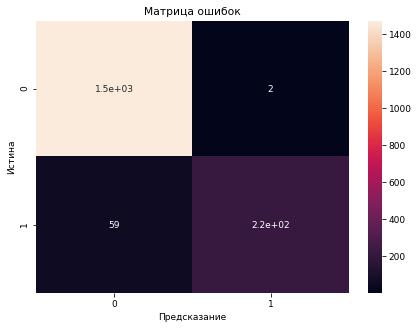

In [67]:
create_conf_matrix(y_test, y_test_pred)

Видно, что ложноотрицательных и ложноположительных примеров всего 59 и 2. Модель правильно предсказала ушедших клиентов в 216 случаев и правильно предсказала что клиент останется в 1472 случаев. 2 клиентам модель предсказала уход, но они остались. 59 клиентам модель присвоила класс "не уйдет", хотя они ушли.

array([[1459,   15],
       [  45,  230]])

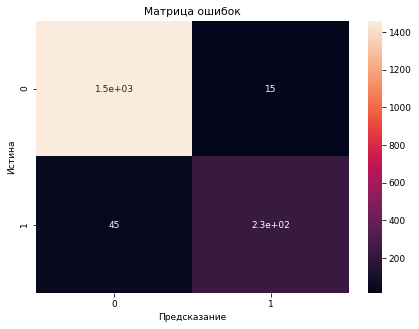

In [68]:
create_conf_matrix(y_test, net_bin_preds)

Ложноотрицательных и ложноположительных примеров стало больше (52 и 18). При этом НС лучше предсказала ушедших клиентов (224 против 216, предсказанных с помощью Catboost) и правильно предсказала что клиент останется в 1461 случае. 13 клиентам модель предсказала уход, но они остались. 51 клиенту модель присвоила класс "не уйдет", хотя они ушли. 
<br>Если стоит задача построить модель, которая лучше определяет будущий уход клиента, то НС с этой задачей справилась несколько лучше, чем catboost несмотря на более низкую метрику точности.

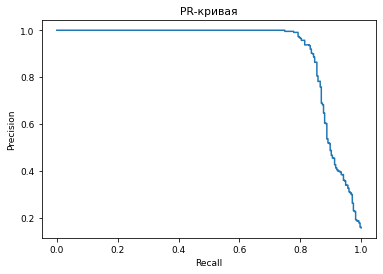

In [69]:
# отобразим полноту и точность модели catboost на графике
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)

# Строим PR-кривую
plt.plot(recall, precision)

# Добавляем подписи осей и заголовок графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая');

По вертикальной оси отложена точность (precision), или доля верно определяемых моделью ушедших клиентов. По горизонтальной оси полнота (recall), или доля верно определяемых моделью ушедших клиентов от общего числа клиентов.

In [70]:
# выведем наиболее важные признаки для модели
X_train_2 = pd.DataFrame(data=data_preprocessor.fit_transform(X_train), 
                         columns=data_preprocessor.get_feature_names_out())

# Создадим лучшую модель
model = CatBoostClassifier(silent=True)
model.fit(X_train_2, y_train)

# Создадим датафрейм с важностями признаков, выведем 10 самых важных признаков
features = {'feature': X_train_2.columns, 'weight': model.feature_importances_}
pd.DataFrame(features).sort_values(by='weight', ascending=False).head(10)

,feature,weight
5,num__TotalCharges,35.328686
6,num__BeginYear,32.454763
4,num__MonthlyCharges,20.032220
1,cat__PaymentMethod,2.816639
7,num__CntServices,2.732122
2,cat__MultipleLines,2.622110
3,cat__StreamingMovies,2.380851
0,cat__Partner,1.632608


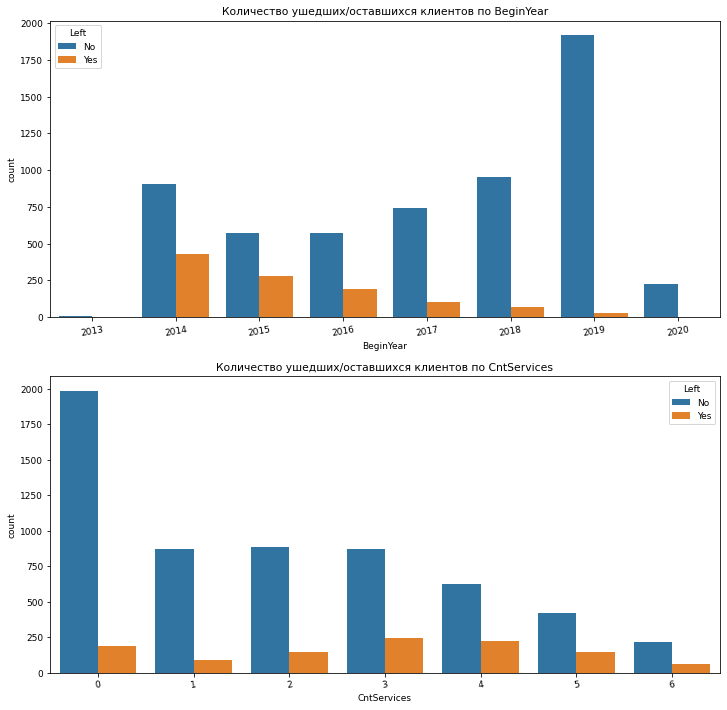

In [71]:
# покажем, как зависит целевая переменная от созданных признаков (BeginYear и CntServices)
temp = ['BeginYear', 'CntServices']

fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axe = axes.ravel()
    
for i, c in enumerate(temp):
    cnt_plot = sns.countplot(x=c, hue = 'Left', data = data_final, ax=axe[i])
    plt.setp(cnt_plot.get_xticklabels(), rotation=10)
    cnt_plot.set(title=f'Количество ушедших/оставшихся клиентов по {c}')

Видно, что чем больше услуг у клиента, тем больше вероятность его ухода. Должно быть услуги оператора не так хороши как у конкурентов.

**Вывод**
<br>Проверка модели CatBoostClassifier на тестовых данных показала, что метрика ROC-AUC на тесте (0,89) оказалась несколько хуже, чем на кросс-валидации, но все-равно выше необходимого порога в 0,85. Расчет метрики accuracy говорит о том, что в 96 из 100 случаев модель точно предсказывает, уйдет ли клиент от оператора связи. Если всем наблюдениям присвоить наиболее частое значение (No), то accuracy будет = 0,84. Построенная матрица ошибок также указывает на малое число наблюдений, классифицированных неправильно. Ложноотрицательных и ложноположительных примеров всего 2 и 61. Анализ важности признаков указывает на то, что наибольший вклад в модель вносят TotalCharges, BeginYear, MonthlyCharges, PaymentMethod и CntServices. В тоже время нейросеть дает несколько лучший результат по предсказанию ухода клиентов, но метрика точности у нее немного ниже, чем у CatBoost.

## Вывод

В данной работе необходимо было решить проблему оттока клиентов у оператора связи. Для борьбы с этим предлагается вариант раздачи промокодов и специальных условий всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, нужна модель, которая будет предсказывать, разорвёт ли абонент договор.
<br>Для работы взяты персональные данные о некоторых клиентах, информация об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.
Лучшую модель необходимо выбрать по метрике ROC-AUC. На тестовой выборке должно быть не менее 0,85. Для интерпретируемости модели дополнительно необходимо вывести значение accuracy.
<br>Для работы представлены 4 таблицы: 
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.

<br>В таблицах contract и personal имются записи о 7043 клиентах. В internet и phone их 5517 и 6361 соответственно. Большинство столбцов в таблицах personal, internet и phone бинарные (Yes или No).
<br>Для работы все таблицы были объеденены в одну. Колонки были приведены к соответствующим форматам. Итоговый признак был определен как уйдет клиент или нет (Yes или No). 
<br>Из построенных гистограмм/ графиков на этапе EDA видно, что данные имеются от 2013 до 2020 года. Заметен рост числа заключенных договоров начиная с 2017 года. Также заметно, что большинство пользователей либо продолжают платить по договору, либо расторгли его в 2020 году. Распредление месячной оплаты походит на нормальное с большим количеством минимальной оплаты, а распределение общих расходов абонента носят геометрический характер. Аномальных значений не выявлено. Также заметно, что по большей части клиенты остаются у нашего оператора связи и не уходят. Большинство клиентов оплачивают услуги ежемесячно, получают электронный расчетный лист. Большинство счетов оплачивается электронно, прочие способы оплаты представленны примерно в равных долях. Нет сильной разницы в распределении пользователей по полу, наличию супруга/супруги, подключенного стримингового телевидиния и каталога фильмов. Большинство пользователей не является пенсионерами, не имеют детей, подключаются по оптическому кабелю, не имеют блокировки опасных сайтов, не пользуются облачным хранилищем, антивирусом, техподдержкой.
<br>По распределению ушедших и оставшихся клиентов можно сделать выводы: 
- чем дольше клиент пользуется услугами оператора, тем больше вероятность его ухода. Поэтому клиентам, которые долго пользуются связью можно раздать бонусы. Клиенты, которые платят больше в месяц также имеют более высокую вероятность ухода;
- не особо сильно влияют на уход клиентов (количество ушедших и оставшихся клиентов в приблизительно равных долях): тип оплаты, пол, наличие электронного расчётного листа, пенсионный ли возраст, наличие детей, тип подключения, наличие тех.поддержки;
- чаще уходят люди с любым способом оплаты кроме отправки бумажного чека, имеющие супруга, имеющие блокировку опасных сайтов, пользующиеся облачным хранилищем и антивирусом, пользующимися услугами стримингового ТВ и каталогом фильмов, а также имеющие подключение телефона к нескольким линиям одновременно.

<br>Также видно, что во всех признаках unknown занимает меньше всего данных.
<br>Судя по построенным корреляциям, данные, взятые ранее из таблиц `internet` и `phone` с заменой пропусков на unknown, почти не влияют на таргет (Left). Если точно заменить пропуски из датафрейма `internet` то корреляция с таргетом в среднем с 0,09 повысится примерно до 0,21. Ниболее сильно с таргетом коррелируют дата начала действия договора и общая оплаченная сумма. 
<br>Стоит отметить, что общая оплаченная сумма косвенно коррелирует с датой начала действия договора, поскольку чем раньше клиент заключил договор, тем больше в итоге он заплатил.
<br>Для работы было разработано 2 новых признака: год заключения договора и количество услуг у клиентов. Оба они неплохо коррелируют с таргетом (Left). В итоге из датасета были оставлены 8 признаков: Parthner, MonthlyCharges, TotalCharges, PaymentMethod, MultipleLines, StreamingMovies, BeginYear, CntServices.
<br>Среди трех моделей, взятых для исследования: RandomForestClassifier, CatBoostClassifier и Нейронная сеть, состоящая из 12 входных нейронов, 8 и 4 нейронов в двух скрытых слоях лучшую метрику на валидации показала модель CatBoostClassifier с метрикой ROC-AUC = 0.946. Для дальнейшей работы была принята модель CatBoostClassifier.
<br>Проверка лучшей модели CatBoostClassifier на тестовых данных показало, что метрика ROC-AUC на тесте (0,89) оказалась несколько хуже, чем на кросс-валидации, но все-равно выше необходимого порога в 0,85. Расчет метрики accuracy говорит о том, что в 96 из 100 случаев модель точно предсказывает, уйдет ли клиент от оператора связи. Если всем наблюдениям присвоить наиболее частое значение (No), то accuracy будет = 0,84. Построенная матрица ошибок также указывает на малое число наблюдений, классифицированных неправильно. Ложноотрицательных и ложноположительных примеров всего 2 и 61. Анализ важности признаков указывает на то, что наибольший вклад в модель вносят TotalCharges, BeginYear, MonthlyCharges и CntServices.

**Рекомендации**
Для увеличения оттока клиентов следует улучшать предоставляемые услуги, т.к. клиенты с большим количеством услуг часто уходят. Также следует устраивать акции для клиентов, которые много платят (более 70 ед. в месяц).